In [1]:
import os
import time
import pickle
import datetime
from tqdm import tqdm
from typing import Any, Callable
import optax
import jax
import jax.random as jr
import jax.numpy as np
import numpy 
from jax.flatten_util import ravel_pytree
from jax import Array, vmap
import matplotlib.pyplot as plt
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from svae_control.config import Config
from pathlib import Path


from dataclasses import asdict
from pathlib import Path

import jax
from jax import random as jr
from matplotlib import pyplot as plt

import wandb
from svae_control import network
from svae_control.config import Config
from svae_control.svae import SVAE
from svae_control.train import Trainer
from svae_control.utils.dataclass_utils import LDSParams
from svae_control.utils.setup_utils import get_args, get_beta_schedule, load_dataset
from svae_control.utils.dataclass_utils import InputData
from svae_control.utils.kernel_ridge import GPUKernelRidge, sweep_krr, standardize

CACHE_DIR = 'tests/results'
SEED = 50
TOLERANCE = 1e-1

YAML_PREFIX = f"{os.getcwd()}"
PARAM_PREFIX = f"{os.getcwd()}/params/svae"
YAML_PREFIX, PARAM_PREFIX

('/home/james/projects/master_project/svae-control/src/svae_control/notebooks/sensor_observations',
 '/home/james/projects/master_project/svae-control/src/svae_control/notebooks/sensor_observations/params/svae')

# Load Data

In [2]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "cifar_observations.npy"))
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

# clean observations
observations = numpy.array(observations)
observations[:, :, 1] = numpy.clip(observations[:, :, 1], -numpy.pi, numpy.pi)
observations[:, :, 3] = numpy.clip(observations[:, :, 3], -numpy.pi, numpy.pi)
observations[:, :, 5] = numpy.clip(observations[:, :, 5], -numpy.pi, numpy.pi)
observations = np.array(observations)

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

((200, 100, 6), (200, 100, 3), (50, 100, 6), (50, 100, 3))

# Config

In [4]:
# config_dir = f"{YAML_PREFIX}/sensor_observations_config.yaml"
# yaml_config = Path(config_dir)
# config = Config.from_yaml(yaml_config)

# key = jr.PRNGKey(config.training.seed)
# data_key, model_key, trainer_key = jr.split(key, 3)

# train_data = InputData(obs=train_X, targets=train_Y)
# val_data = InputData(obs=val_X, targets=val_Y) 

# train_data.obs.shape, val_data.obs.shape

In [3]:
# set up training and val data
train_data = InputData(obs=train_X, targets=train_Y)
val_data = InputData(obs=val_X, targets=val_Y)

train_data.obs.shape, val_data.obs.shape

((200, 100, 6), (50, 100, 6))

In [7]:

for seed in [1, 2]:

    # Load config with specific seed
    config_dir = f"{YAML_PREFIX}/sensor_observations_config_seed_{seed}.yaml"
    yaml_config = Path(config_dir)
    config = Config.from_yaml(yaml_config)
    print("Using seed: ", config.training.seed)

    # generate keys using seed
    key = jr.PRNGKey(config.training.seed)
    data_key, model_key, trainer_key = jr.split(key, 3)

    # to be safe, redefine prior and enc/dec networks for each seed
    prior = LDSParams.init(config.model.latent_dim)
    enc = getattr(network, config.model.encoder.dist_type)(
        config.model.encoder, config.model.latent_dim
    )
    dec = getattr(network, config.model.decoder.dist_type)(
        config.model.decoder, config.data.obs_dim_flat
    )

    # define SVAE and Trainer
    model = SVAE(
        generation_network=dec, recognition_network=enc, config=config, key=model_key
    )
    trainer = Trainer(
        model=model,
        config=config,
        prior_params=prior,
        beta_schedule=get_beta_schedule(config.training.beta),
        key=trainer_key,
        logger=None,
    )

    # fit SVAE
    start = time.perf_counter()
    loss, r2, trained_params = trainer.train(train_data, val_data)
    
    end = time.perf_counter()
    time_elapsed = end - start
    elapsed_filename = f"{PARAM_PREFIX}_time_elapsed_seed_{seed}.pkl"
    with open(elapsed_filename, 'wb') as f:
        pickle.dump(time_elapsed, f)
    
    # save params
    filename = f"{PARAM_PREFIX}_params_seed_{seed}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(trainer.params, f)
    
    # save loss tot
    loss = np.array(loss)
    filename = f"{PARAM_PREFIX}_training_loss_seed_{seed}"
    np.save(filename, loss)

Using seed:  1



00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:14:22<00:00,  2.24it/s, kl=0.061, loss=1.057, obs_ll=-0.996, r2_post=0.934]

Using seed:  2



00%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:13:27<00:00,  2.27it/s, kl=0.060, loss=1.059, obs_ll=-1.000, r2_post=0.930]

In [7]:
# prior = LDSParams.init(config.model.latent_dim)
# enc = getattr(network, config.model.encoder.dist_type)(
#     config.model.encoder, config.model.latent_dim
# )
# dec = getattr(network, config.model.decoder.dist_type)(
#     config.model.decoder, config.data.obs_dim_flat
# )

# model = SVAE(
#     generation_network=dec, recognition_network=enc, config=config, key=model_key
# )
# trainer = Trainer(
#     model=model,
#     config=config,
#     prior_params=prior,
#     beta_schedule=get_beta_schedule(config.training.beta),
#     key=trainer_key,
#     logger=None,
# )
# loss, r2, trained_params = trainer.train(train_data, val_data)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:10:43<00:00,  2.36it/s, kl=0.061, loss=1.034, obs_ll=-0.973, r2_post=0.970]

In [8]:
# # save params
# filename = f"{PARAM_PREFIX}_params.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(trainer.params, f)

# # save loss tot
# loss = np.array(loss)
# filename = f"{PARAM_PREFIX}_training_loss.pkl"
# np.save(filename, loss)

# Plot Learned Transition Matrix A and Loss

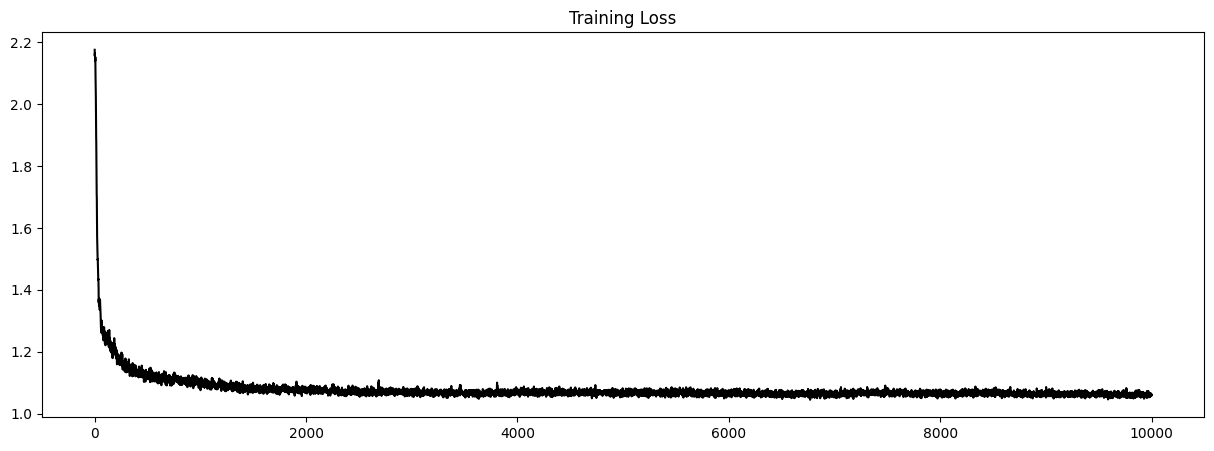

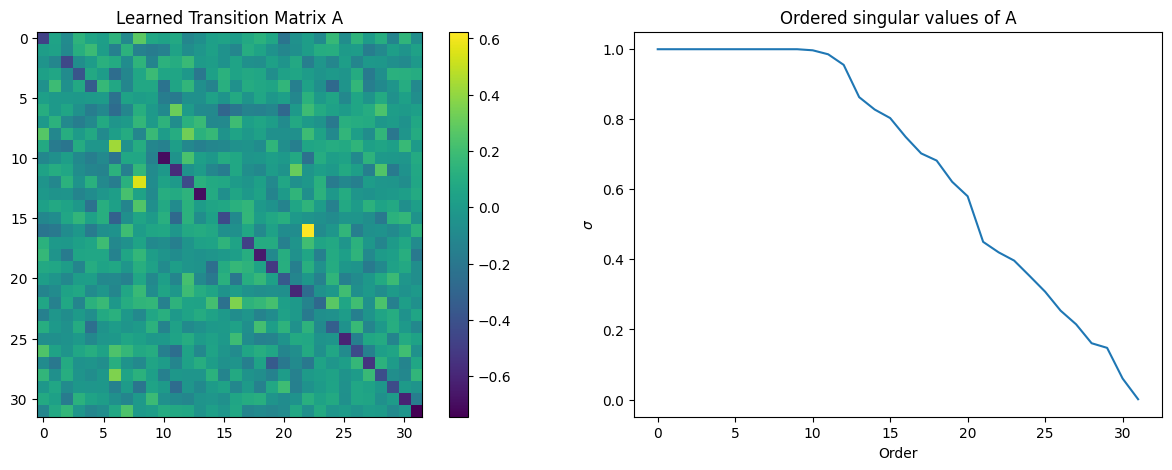

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(loss, color="black")
plt.title("Training Loss")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
A = numpy.array(trainer.params[0].A)
im = ax[0].imshow(A)
ax[0].set_title("Learned Transition Matrix A")
fig.colorbar(im, ax=ax[0])

U, S, VT = numpy.linalg.svd(A)
rank = numpy.linalg.matrix_rank(A)
ax[1].plot(numpy.arange(S.shape[0]), S)
ax[1].set_title("Ordered singular values of A")
ax[1].set_ylabel(r"$\sigma\ $")
ax[1].set_xlabel("Order")

plt.show()

# Check Latent Quality with Kernel Ridge

In [5]:
aux_list = []
for seed in range(0, 3):

    # Load config with specific seed
    config_dir = f"{YAML_PREFIX}/sensor_observations_config_seed_{seed}.yaml"
    yaml_config = Path(config_dir)
    config = Config.from_yaml(yaml_config)

    # generate keys using seed
    key = jr.PRNGKey(config.training.seed)
    data_key, model_key, trainer_key = jr.split(key, 3)

    # to be safe, redefine prior and enc/dec networks for each seed
    prior = LDSParams.init(config.model.latent_dim)
    enc = getattr(network, config.model.encoder.dist_type)(
        config.model.encoder, config.model.latent_dim
    )
    dec = getattr(network, config.model.decoder.dist_type)(
        config.model.decoder, config.data.obs_dim_flat
    )

    # define SVAE and Trainer
    model = SVAE(
        generation_network=dec, recognition_network=enc, config=config, key=model_key
    )
    trainer = Trainer(
        model=model,
        config=config,
        prior_params=prior,
        beta_schedule=get_beta_schedule(config.training.beta),
        key=trainer_key,
        logger=None,
    )

    # load params
    filename = f"{PARAM_PREFIX}_params_seed_{seed}.pkl"
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    
    trainer.params = params

    # get posterior estimates
    apply = vmap(model.apply, (None, 0))
    train_ts_means = apply(trainer.params, train_X).smoothed_means
    val_ts_means = apply(trainer.params, val_X).smoothed_means
    
    # standardize the posterior means output
    train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)
    sigma_range = np.arange(0.01, 5, 0.25)
    lambda_range = np.arange(0.001, 1, 0.1)
    krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
    aux_list.append(aux)

aux_list




itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.39s/it]

[{'sigma': Array(2.7599998, dtype=float32),
  'lambda': Array(0.101, dtype=float32),
  'r2': Array(0.8111322, dtype=float32)},
 {'sigma': Array(1.7599999, dtype=float32),
  'lambda': Array(0.101, dtype=float32),
  'r2': Array(0.9194819, dtype=float32)},
 {'sigma': Array(1.5099999, dtype=float32),
  'lambda': Array(0.101, dtype=float32),
  'r2': Array(0.92092437, dtype=float32)}]

In [2]:
r2 = numpy.array([0.8111322, 0.9194819, 0.92092437])
print("Mean: ", r2.mean(), "Std: ", r2.std())

elapsed_filename_1 = f"{PARAM_PREFIX}_time_elapsed_seed_1.pkl"
elapsed_filename_2 = f"{PARAM_PREFIX}_time_elapsed_seed_2.pkl"
with open(elapsed_filename_1, 'rb') as f:
    elapsed_time_1 = pickle.load(f)
with open(elapsed_filename_2, 'rb') as f:
    elapsed_time_2 = pickle.load(f)

times = 10000 / numpy.array([elapsed_time_1, elapsed_time_2])
times.mean(), times.std(), times

Mean:  0.8838461566666668 Std:  0.05141990406134338


(2.4086509679917993, 0.026436770964386902, array([2.3822142 , 2.43508774]))

# Example Trajectory

In [ ]:
krr_preds = krr.predict(train_ts_means)
# val_krr_preds = krr.predict(val_X)

fig, ax = plt.subplots(1, 4, figsize=(15, 4))
counter = 0
for i in range(4):
    ax[i].plot(train_Y[counter, :, 0], train_Y[counter, :, 1], label="Truth")
    ax[i].plot(krr_preds[counter, :, 0], krr_preds[counter, :, 1], label="KRR Preds")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
    ax[i].legend()
    counter += 1
plt.show()

In [9]:
apply = vmap(model.apply, (None, 0))
train_ts_means = apply(trained_params, train_X).smoothed_means
val_ts_means = apply(trained_params, val_X).smoothed_means

# standardize the posterior means output
train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)

In [10]:
train_ts_means.shape, val_ts_means.shape

((200, 100, 32), (50, 100, 32))

In [11]:
sigma_range = np.arange(0.01, 2, 0.1)
lambda_range = np.arange(0.001, 0.2, 0.02)
krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
aux


itting KRR: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.81s/it]

{'sigma': Array(1.01, dtype=float32),
 'lambda': Array(0.021, dtype=float32),
 'r2': Array(0.94493914, dtype=float32)}

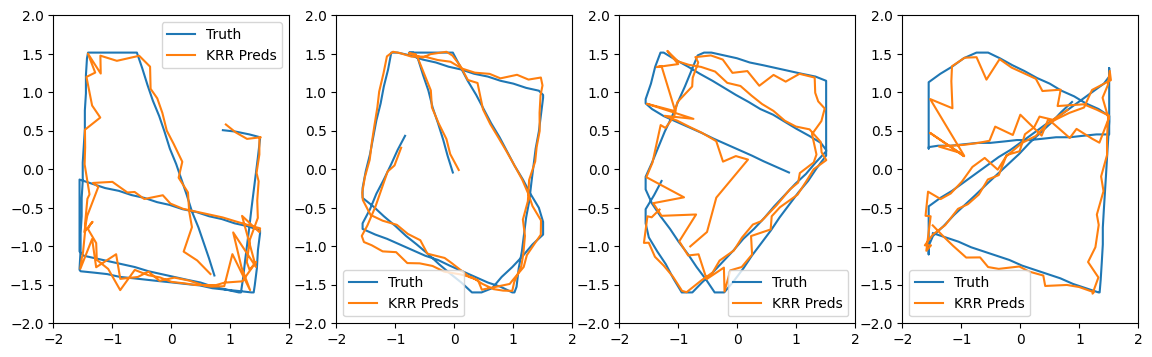

In [12]:
krr_preds = krr.predict(train_ts_means)
# val_krr_preds = krr.predict(val_X)

fig, ax = plt.subplots(1, 4, figsize=(14, 4))
counter = 0
for i in range(4):
    ax[i].plot(train_Y[counter, :, 0], train_Y[counter, :, 1], label="Truth")
    ax[i].plot(krr_preds[counter, :, 0], krr_preds[counter, :, 1], label="KRR Preds")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
    ax[i].legend()
    counter += 1
plt.show()